<a href="https://colab.research.google.com/github/labphonlab/L2_Lexical_Importance/blob/main/Lexical_Importance_BLC_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cell 1: 環境構築と設定 (Setup & Utils)

In [9]:
# ==========================================
# Cell 1: Setup, Configuration & Checkpoint Utils
# ==========================================

# 1. 必要なライブラリのインストール (ここが重要です)
!pip install -q wordfreq nltk matplotlib seaborn scikit-learn

import os
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tqdm.auto import tqdm
import nltk
from wordfreq import zipf_frequency, top_n_list
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from nltk.corpus import cmudict, stopwords
from collections import defaultdict

# 2. Google Driveのマウント
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 3. パス設定
# Note: Adjust this path to your own environment before running
PROJECT_ROOT = '/content/drive/MyDrive/L2_Lexical_Importance_v2'
DATA_DIR = f"{PROJECT_ROOT}/01_Data/02_processed"
FIG_DIR  = f"{PROJECT_ROOT}/03_Results/figures"
TBL_DIR  = f"{PROJECT_ROOT}/03_Results/tables"
CKPT_DIR = f"{PROJECT_ROOT}/00_Checkpoints"

# フォルダ作成
for d in [DATA_DIR, FIG_DIR, TBL_DIR, CKPT_DIR]:
    os.makedirs(d, exist_ok=True)

# 4. NLTKデータのダウンロード
nltk.download('cmudict', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('universal_tagset', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# 5. チェックポイント用関数
def save_checkpoint(filename, data, processed_set, extra_data=None):
    """Save progress to a pickle file."""
    path = f"{CKPT_DIR}/{filename}"
    payload = {'data': data, 'processed': processed_set}
    if extra_data is not None:
        payload['extra'] = extra_data
    with open(path, 'wb') as f:
        pickle.dump(payload, f)

def load_checkpoint(filename):
    """Load progress from a pickle file."""
    path = f"{CKPT_DIR}/{filename}"
    if os.path.exists(path):
        print(f"🔄 Resuming from checkpoint: {path}")
        with open(path, 'rb') as f:
            content = pickle.load(f)
        extra = content.get('extra', None)
        return content['data'], content['processed'], extra
    return [], set(), None

def clear_checkpoint(filename):
    """Remove checkpoint file after completion."""
    path = f"{CKPT_DIR}/{filename}"
    if os.path.exists(path):
        os.remove(path)
        print(f"✅ Checkpoint cleared: {filename}")

print(f"\n環境構築完了。Project Root: {PROJECT_ROOT}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 14.6 MB/s eta 0:00:00
Mounted at /content/drive

環境構築完了。Project Root: /content/drive/MyDrive/L2_Lexical_Importance_v2


### Cell 2: データ生成と競合リスク計算 (Main Data Generation)

In [10]:
# ==========================================
# Cell 2: Main Data Generation (Resumable)
# ==========================================

# --- Configuration ---
IPHOD_PATH = f"{PROJECT_ROOT}/01_Data/01_raw/iphod_data.csv"
cmu = cmudict.dict()

# --- Helpers ---
_iphod_cache = None
def get_iphod_dict():
    global _iphod_cache
    if _iphod_cache: return _iphod_cache
    if not os.path.exists(IPHOD_PATH):
        raise FileNotFoundError(f"IPhOD file not found at: {IPHOD_PATH}")
    print("Loading IPhOD data...")
    df = pd.read_csv(IPHOD_PATH, sep='\t', encoding='utf-8')
    df.columns = df.columns.str.strip()
    # Find columns dynamically
    w_col = next((c for c in df.columns if c.lower() in ['word', 'orthography']), df.columns[1])
    p_col = next((c for c in df.columns if 'prob' in c.lower() or 'bpa' in c.lower()), df.columns[-1])

    df['word_lower'] = df[w_col].astype(str).str.lower()
    _iphod_cache = dict(zip(df['word_lower'], df[p_col]))
    return _iphod_cache

def process_single_word(word, iphod_dict):
    if (word not in cmu) or (word not in iphod_dict): return None
    try:
        pos = nltk.pos_tag([word], tagset='universal')[0][1]
    except: return None

    # Categorize
    is_content = (word not in stopwords.words('english')) and (pos in ['NOUN', 'VERB', 'ADJ', 'ADV'])

    pron = cmu[word][0]
    freq = zipf_frequency(word, 'en')
    p_raw = iphod_dict[word]
    p_log = np.log(p_raw) if p_raw > 0 else np.nan

    # Instability Heuristic
    instab = sum(1 for p in pron if 'AH0' in p)
    if pron[-1][:2] in ['P', 'T', 'K', 'B', 'D', 'G', 'F', 'V', 'S', 'Z', 'TH', 'DH']: instab += 1
    max_c, cur_c = 0, 0
    for p in pron:
        if not p[-1].isdigit(): cur_c += 1
        else: max_c, cur_c = max(max_c, cur_c), 0
    if max_c >= 3: instab += 1

    return {
        'word': word, 'pron': pron, 'pos': pos,
        'category': 'Content' if is_content else 'Function',
        'frequency_zipf': freq,
        'phonotactic_prob_raw': p_raw, 'log_phonotactic_prob': p_log,
        'phonetic_instability': instab
    }

# --- Task 1: Word Collection ---
def run_collection(target=3000):
    iphod = get_iphod_dict()
    candidates = top_n_list('en', target * 5)
    CKPT = "step1_collection.pkl"

    data, processed, _ = load_checkpoint(CKPT)
    content_count = sum(1 for d in data if d['category'] == 'Content')

    if content_count >= target:
        print("Data collection already complete.")
        return pd.DataFrame(data)

    print(f"Collecting words... (Current: {content_count}/{target})")
    pbar = tqdm(total=target, initial=content_count)

    for word in candidates:
        if content_count >= target: break
        if word in processed: continue

        res = process_single_word(word, iphod)
        processed.add(word)

        if res:
            data.append(res)
            if res['category'] == 'Content':
                content_count += 1
                pbar.update(1)

            if len(data) % 200 == 0:
                save_checkpoint(CKPT, data, processed)

    pbar.close()
    if content_count >= target: clear_checkpoint(CKPT)
    return pd.DataFrame(data)

# --- Task 2: Risk Calculation ---
def run_risk_calc(df, task_name="content_risk"):
    CKPT = f"step2_{task_name}.pkl"
    w_list = df['word'].tolist()
    p_list = df['pron'].tolist()
    f_list = df['frequency_zipf'].tolist()
    n = len(w_list)

    risks, processed_idx, _ = load_checkpoint(CKPT)

    # Initialize if empty or mismatched
    if len(risks) != n:
        risks = [None] * n
        processed_idx = set()
    elif len(processed_idx) == n:
        print(f"Risk calculation already complete for {task_name}.")
        return risks

    print(f"Calculating Competition Risk for {task_name}...")
    pbar = tqdm(total=n, initial=len(processed_idx))

    # Pre-compute lengths for speed
    p_lens = [len(p) for p in p_list]

    for i in range(n):
        if i in processed_idx: continue

        score = 0
        t_pron, t_len = p_list[i], p_lens[i]

        # O(N^2) loop
        for j in range(n):
            if i == j: continue
            if abs(t_len - p_lens[j]) > 1: continue
            if nltk.edit_distance(t_pron, p_list[j]) == 1:
                score += f_list[j]

        risks[i] = score
        processed_idx.add(i)
        pbar.update(1)

        if len(processed_idx) % 500 == 0:
            save_checkpoint(CKPT, risks, processed_idx)

    pbar.close()
    clear_checkpoint(CKPT)
    return risks

# --- Main Execution ---
try:
    # 1. Collect
    df_all = run_collection(target=3000)

    # 2. Split
    df_content = df_all[df_all['category'] == 'Content'].copy().reset_index(drop=True)
    df_function = df_all[df_all['category'] == 'Function'].copy().reset_index(drop=True)

    # 3. Risk Calc (Content Only)
    risks = run_risk_calc(df_content, "content")
    df_content['competition_risk'] = risks

    # Save
    df_content.to_csv(f"{DATA_DIR}/lexical_data_content.csv", index=False)
    df_function.to_csv(f"{DATA_DIR}/lexical_data_function.csv", index=False)
    print("Main data generation complete.")

except Exception as e:
    print(f"\nStopped due to: {e}")
    print("Run this cell again to resume.")

Loading IPhOD data...


  0%|          | 0/3000 [00:00<?, ?it/s]

✅ Checkpoint cleared: step1_collection.pkl
Calculating Competition Risk for content...


  0%|          | 0/3000 [00:00<?, ?it/s]

✅ Checkpoint cleared: step2_content.pkl
Main data generation complete.


### Cell 3: 分析とクラスタリング (Content Word Analysis)

In [11]:
# ==========================================
# Cell 3: Content Word Analysis (Stats & Clustering)
# ==========================================

# 1. Load Data
df_analysis = pd.read_csv(f"{DATA_DIR}/lexical_data_content.csv")

# 2. Preprocessing
features = ['frequency_zipf', 'log_phonotactic_prob', 'competition_risk', 'phonetic_instability']
before_len = len(df_analysis)
df_analysis = df_analysis.dropna(subset=features) # Drop NaNs (e.g., log(0))
print(f"Dropped {before_len - len(df_analysis)} words due to missing values.")

# 3. Statistics (Table 1)
desc_stats = df_analysis[features].describe()
desc_stats.to_csv(f"{TBL_DIR}/descriptive_stats_content.csv")
print("--- Table 1: Descriptive Statistics ---")
display(desc_stats)

# 4. Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis[features])
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_analysis['cluster'] = kmeans.fit_predict(X_scaled)

# 5. Centroids (Table 3)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
centroids['cluster'] = range(5)
centroids.to_csv(f"{TBL_DIR}/cluster_centroids.csv", index=False)
print("--- Table 3: Cluster Centroids (Z-score) ---")
display(centroids)

# Save Clustered Data
df_analysis.to_csv(f"{DATA_DIR}/lexical_data_content_clustered.csv", index=False)

Dropped 4 words due to missing values.
--- Table 1: Descriptive Statistics ---


,frequency_zipf,log_phonotactic_prob,competition_risk,phonetic_instability
count,2996.000000,2996.000000,2996.000000,2996.000000
mean,4.862513,-5.687084,13.348324,1.006342
std,0.333760,0.845070,20.326890,0.838729
min,4.450000,-10.197859,0.000000,0.000000
25%,4.600000,-6.190067,0.000000,0.000000
50%,4.780000,-5.524700,4.900000,1.000000
75%,5.050000,-5.043640,15.662500,1.000000
max,6.290000,-3.993212,120.620000,4.000000


--- Table 3: Cluster Centroids (Z-score) ---


,frequency_zipf,log_phonotactic_prob,competition_risk,phonetic_instability,cluster
0,-0.447145,0.466332,-0.327471,-0.368445,0
1,-0.372414,0.615052,-0.540576,1.467528,1
2,1.582593,0.073361,0.022954,-0.349425,2
3,-0.237237,-1.378081,-0.024084,-0.557402,3
4,0.545315,-0.869113,2.560843,-0.643833,4


### Cell 4: 可視化 (Visualization)

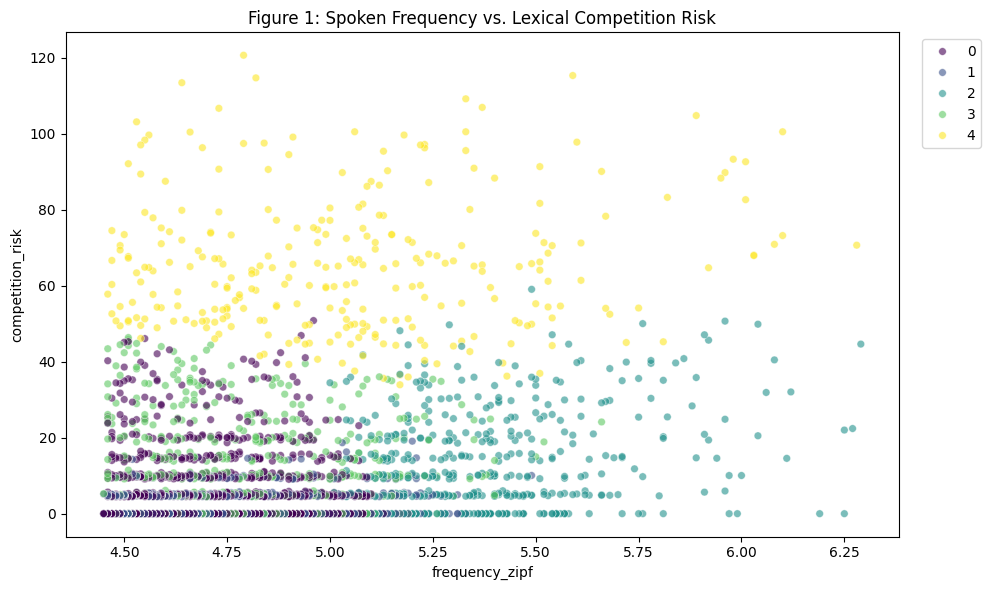

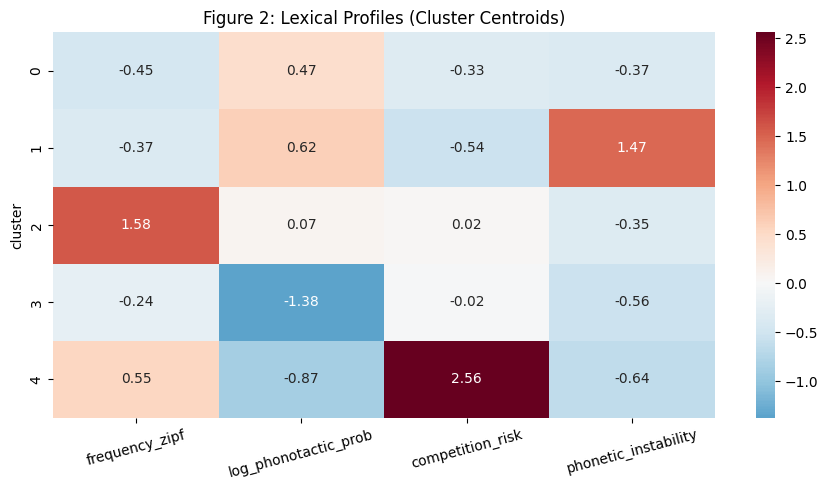

In [12]:
# ==========================================
# Cell 4: Visualization (Figures 1 & 2)
# ==========================================

# Figure 1: Frequency vs Risk
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_analysis, x='frequency_zipf', y='competition_risk',
    hue='cluster', palette='viridis', alpha=0.6, s=30
)
plt.title('Figure 1: Spoken Frequency vs. Lexical Competition Risk')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Fig1_Freq_vs_Competition.png", dpi=300)
plt.show()

# Figure 2: Profiles Heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(
    centroids.set_index('cluster'), annot=True, cmap='RdBu_r', center=0, fmt='.2f'
)
plt.title('Figure 2: Lexical Profiles (Cluster Centroids)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Fig2_Lexical_Profiles.png", dpi=300)
plt.show()

### Cell 5: 機能語の詳細分析 (Supplementary Analysis)

Analyzing Function Words... (Processed: 0/176)


  0%|          | 0/176 [00:00<?, ?it/s]

✅ Checkpoint cleared: step3_func_analysis.pkl
Supplementary Tables Saved.


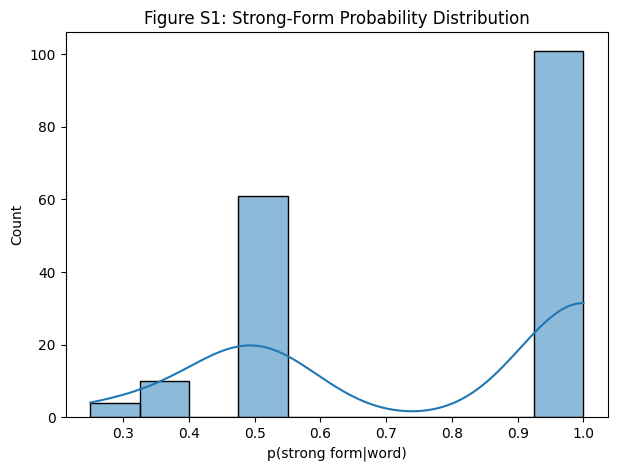

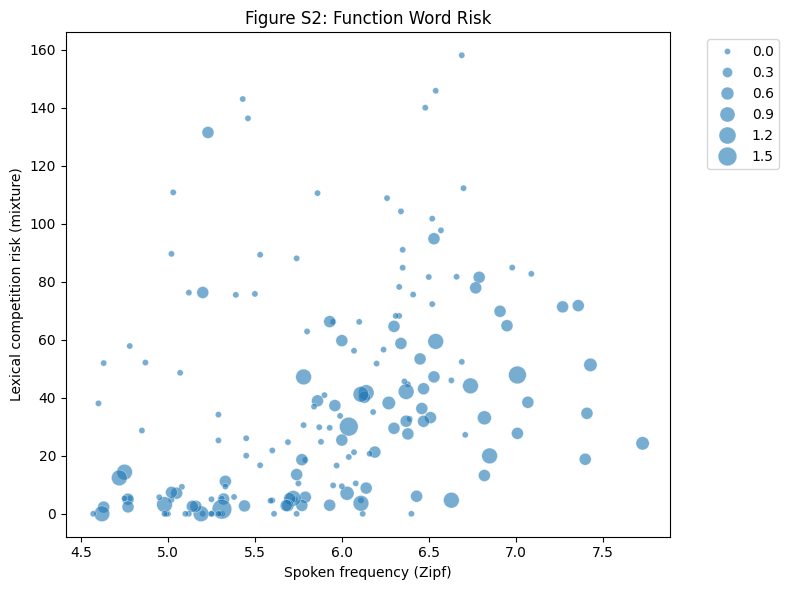

In [13]:
# ==========================================
# Cell 5: Function Word Analysis (Resumable & Detailed)
# ==========================================

PROB_DATA_PATH = f"{PROJECT_ROOT}/01_Data/01_raw/variant_probabilities.csv"

# --- Utils ---
def load_prob_dict():
    if not os.path.exists(PROB_DATA_PATH):
        print("Warning: Corpus probability file not found. Using heuristic.")
        return None
    df = pd.read_csv(PROB_DATA_PATH)
    return dict(zip(zip(df['word'].astype(str), df['pron'].astype(str)), df['prob']))

def get_bigram_model():
    bg_counts = defaultdict(int)
    total = 0
    for w, prons in cmu.items():
        p = prons[0]
        for i in range(len(p)-1):
            bg_counts[(p[i], p[i+1])] += 1
            total += 1
    return bg_counts, total

# --- Setup ---
corpus_probs = load_prob_dict()
bg_counts, bg_total = get_bigram_model()
df_func_input = pd.read_csv(f"{DATA_DIR}/lexical_data_function.csv")

# Global lexicon for risk calc
if 'df_analysis' in locals():
    all_lexicon = pd.concat([df_analysis, df_func_input], ignore_index=True)
else:
    all_lexicon = df_func_input # Fallback
all_prons = all_lexicon['pron'].apply(eval).tolist() if isinstance(all_lexicon['pron'].iloc[0], str) else all_lexicon['pron'].tolist()
all_freqs = all_lexicon['frequency_zipf'].tolist()

def calc_bg_prob(pron):
    if len(pron) < 2: return -10.0
    log_sum = sum(np.log((bg_counts[(pron[i], pron[i+1])] + 1) / (bg_total + len(bg_counts)))
                  for i in range(len(pron)-1))
    return log_sum / (len(pron)-1)

def analyze_func_word(row):
    word = row['word']
    freq = row['frequency_zipf']
    if word not in cmu: return None, []

    variants = cmu[word]
    # Determine probabilities
    if corpus_probs:
        raw_p = [corpus_probs.get((word, " ".join(v)), 0.0) for v in variants]
        total = sum(raw_p)
        probs = [p/total for p in raw_p] if total > 0 else [1/len(variants)]*len(variants)
    else:
        probs = [1.0] if len(variants)==1 else [0.3] + [0.7/(len(variants)-1)]*(len(variants)-1)

    # Calculate Metrics
    w_phon, w_comp, w_instab = 0, 0, 0
    strong_form = variants[0]
    var_rows = []

    for i, pron in enumerate(variants):
        p = probs[i]
        pron_str = " ".join(pron)
        var_rows.append({'Function word': word, 'Variant': i+1, 'Pron': pron_str, 'Prob': p})

        if p == 0: continue
        w_phon += calc_bg_prob(pron) * p
        w_instab += nltk.edit_distance(strong_form, pron) * p

        # Risk (Simplified loop)
        comp = 0
        plen = len(pron)
        # Optimization: Only check relevant length neighbors
        for j, n_pron in enumerate(all_prons):
            # Evaluate string vs list carefully
            np_seq = n_pron if isinstance(n_pron, list) else eval(str(n_pron))
            if abs(plen - len(np_seq)) > 1: continue
            if nltk.edit_distance(pron, np_seq) == 1:
                comp += all_freqs[j]
        w_comp += comp * p

    agg = {
        'Function word': word, 'Spoken frequency (Zipf)': freq,
        'Phonotactic probability (mixture)': w_phon,
        'Lexical competition risk (mixture)': w_comp,
        'Phonetic instability (mixture)': w_instab,
        'p(strong form|word)': probs[0]
    }
    return agg, var_rows

# --- Execution ---
CKPT = "step3_func_analysis.pkl"
agg_data, processed, extra_vars = load_checkpoint(CKPT)
var_data = extra_vars if extra_vars else []

print(f"Analyzing Function Words... (Processed: {len(processed)}/{len(df_func_input)})")
pbar = tqdm(total=len(df_func_input), initial=len(processed))

for _, row in df_func_input.iterrows():
    if row['word'] in processed: continue

    agg, vars_list = analyze_func_word(row)
    if agg:
        agg_data.append(agg)
        var_data.extend(vars_list)
        processed.add(row['word'])
        pbar.update(1)

    if len(agg_data) % 50 == 0:
        save_checkpoint(CKPT, agg_data, processed, var_data)

pbar.close()
clear_checkpoint(CKPT)

# Save Outputs
df_s3 = pd.DataFrame(agg_data)
df_s2 = pd.DataFrame(var_data)
df_s3.to_csv(f"{TBL_DIR}/Table_S3_Function_Measures.csv", index=False)
df_s2.to_csv(f"{TBL_DIR}/Table_S2_Function_Variants.csv", index=False)
print("Supplementary Tables Saved.")

# --- Visualization ---
# Fig S1
plt.figure(figsize=(7, 5))
sns.histplot(data=df_s3, x='p(strong form|word)', bins=10, kde=True)
plt.title('Figure S1: Strong-Form Probability Distribution')
plt.savefig(f"{FIG_DIR}/FigS1_StrongForm_Dist.png")
plt.show()

# Fig S2
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_s3, x='Spoken frequency (Zipf)', y='Lexical competition risk (mixture)',
                size='Phonetic instability (mixture)', sizes=(20, 200), alpha=0.6)
plt.title('Figure S2: Function Word Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/FigS2_Func_Freq_vs_Comp.png")
plt.show()

### Cell 6: 残りの出力 (Table 2 & Appendix A)

In [14]:
# ==========================================
# Cell 6: Final Tables (Table 2 & Appendix A)
# ==========================================

# 1. Table 2: Cluster Sizes
counts = df_analysis['cluster'].value_counts().sort_index()
table2 = pd.DataFrame({
    'Cluster': counts.index,
    'N': counts.values,
    '%': (counts.values / len(df_analysis) * 100).round(2)
})
table2.to_csv(f"{TBL_DIR}/Table2_Cluster_Sizes.csv", index=False)
print("--- Table 2: Cluster Sizes ---")
display(table2)

# 2. Appendix A: Representative Items
app_rows = []
for c in sorted(df_analysis['cluster'].unique()):
    sub = df_analysis[df_analysis['cluster'] == c]
    top_words = sub.sort_values('frequency_zipf', ascending=False)['word'].head(30).tolist()
    app_rows.append({'Cluster': c, 'Items': ", ".join(top_words)})

df_app = pd.DataFrame(app_rows)
df_app.to_csv(f"{TBL_DIR}/Appendix_A_Representative_Items.csv", index=False)
print("--- Appendix A: Representative Items ---")
pd.set_option('display.max_colwidth', 100)
display(df_app)

--- Table 2: Cluster Sizes ---


,Cluster,N,%
0,0,1065,35.55
1,1,692,23.10
2,2,443,14.79
3,3,513,17.12
4,4,283,9.45


--- Appendix A: Representative Items ---


,Cluster,Items
0,0,"trust, cannot, related, title, enjoy, entire, decided, decision, situation, written, continue, c..."
1,1,"american, international, police, minutes, development, services, political, education, available..."
2,2,"time, would, people, new, also, good, first, think, could, want, back, much, even, really, need,..."
3,3,"put, power, job, south, food, wrong, girl, yeah, move, cause, watch, age, major, type, father, b..."
4,4,"get, see, know, make, well, go, way, said, may, right, day, made, say, man, look, high, game, sh..."


In [15]:
# ==========================================
# Cell 7: Download All Results
# ==========================================
import os
import zipfile
from google.colab import files

# パスの定義（これまでのセルと同じ設定）
PROJECT_ROOT = '/content/drive/MyDrive/L2_Lexical_Importance_v2'
TBL_DIR = f"{PROJECT_ROOT}/03_Results/tables"
FIG_DIR = f"{PROJECT_ROOT}/03_Results/figures"

# ダウンロード対象のファイルリスト
target_files = {
    # Tables
    "Table1_Descriptive.csv": f"{TBL_DIR}/descriptive_stats_content.csv",
    "Table2_ClusterSizes.csv": f"{TBL_DIR}/Table2_Cluster_Sizes.csv",
    "Table3_Centroids.csv": f"{TBL_DIR}/cluster_centroids.csv",
    "AppendixA_Items.csv": f"{TBL_DIR}/Appendix_A_Representative_Items.csv",
    "TableS2_FuncVariants.csv": f"{TBL_DIR}/Table_S2_Function_Variants.csv",
    "TableS3_FuncMeasures.csv": f"{TBL_DIR}/Table_S3_Function_Measures.csv",

    # Figures
    "Fig1_Freq_vs_Comp.png": f"{FIG_DIR}/Fig1_Freq_vs_Competition.png",
    "Fig2_LexicalProfiles.png": f"{FIG_DIR}/Fig2_Lexical_Profiles.png",
    "FigS1_StrongForm.png": f"{FIG_DIR}/FigS1_StrongForm_Dist.png",
    "FigS2_FuncRisk.png": f"{FIG_DIR}/FigS2_Func_Freq_vs_Comp.png"
}

zip_filename = "/content/L2_Lexical_Results.zip"

print("ファイルを圧縮しています...")

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    found_count = 0
    for name, path in target_files.items():
        if os.path.exists(path):
            # ZIP内ではフォルダ階層を作らずフラットにするか、整理するか
            # ここでは分かりやすく 'tables/' と 'figures/' に分けます
            arcname = f"tables/{name}" if "csv" in name else f"figures/{name}"
            zipf.write(path, arcname=arcname)
            print(f"  OK: {name}")
            found_count += 1
        else:
            print(f"  MISSING: {name} (パス: {path})")

if found_count > 0:
    print(f"\n{found_count} 個のファイルを圧縮しました。ダウンロードを開始します...")
    files.download(zip_filename)
else:
    print("\nダウンロード対象のファイルが見つかりませんでした。Cell 1〜6が正常に完了しているか確認してください。")

ファイルを圧縮しています...
  OK: Table1_Descriptive.csv
  OK: Table2_ClusterSizes.csv
  OK: Table3_Centroids.csv
  OK: AppendixA_Items.csv
  OK: TableS2_FuncVariants.csv
  OK: TableS3_FuncMeasures.csv
  OK: Fig1_Freq_vs_Comp.png
  OK: Fig2_LexicalProfiles.png
  OK: FigS1_StrongForm.png
  OK: FigS2_FuncRisk.png

10 個のファイルを圧縮しました。ダウンロードを開始します...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# ==========================================
# Cell 8: Generate Repository-Ready Datasets
# ==========================================
import os
import pandas as pd

# 保存先フォルダ (リポジトリ提出用)
REPO_DIR = f"{PROJECT_ROOT}/04_Repository_Submission"
os.makedirs(REPO_DIR, exist_ok=True)

print("リポジトリ提出用データセットを作成します...")

# ---------------------------------------------------------
# 1. Primary Content-Word Dataset (N ≈ 3000)
# ---------------------------------------------------------
# 前提: Cell 3 で作成した df_analysis (欠損除去・クラスタリング済み) を使用
if 'df_analysis' not in locals():
    raise ValueError("df_analysis が見つかりません。Cell 3 を実行してください。")

# 必要な列のみ抽出・リネーム
# ユーザー指定: word/lemma, pos, spoken_frequency, log_phon_prob, comp_risk, instability, cluster
df_primary = df_analysis[[
    'word', 'pos', 'frequency_zipf', 'log_phonotactic_prob',
    'competition_risk', 'phonetic_instability', 'cluster'
]].copy()

# 列名の整形 (より一般的で分かりやすい名前に)
df_primary.columns = [
    'word', 'pos_tag', 'spoken_frequency_zipf', 'log_phonotactic_probability',
    'lexical_competition_risk', 'phonetic_instability', 'cluster_label'
]

# 行数の確認
N_content = len(df_primary)
print(f"▼ Primary Dataset (Content Words): N = {N_content}")

# 保存
path_primary = f"{REPO_DIR}/dataset_content_words_N{N_content}.csv"
df_primary.to_csv(path_primary, index=False)
print(f"  Saved: {path_primary}")


# ---------------------------------------------------------
# 2. Supplementary Function-Word Dataset
# ---------------------------------------------------------
# 前提: Cell 5 で作成した df_s3 (混合モデル指標) を使用
if 'df_s3' not in locals():
    raise ValueError("df_s3 が見つかりません。Cell 5 を実行してください。")

# 必要な列を抽出
df_supplementary = df_s3[[
    'Function word', 'Spoken frequency (Zipf)',
    'Phonotactic probability (mixture)', 'Lexical competition risk (mixture)',
    'Phonetic instability (mixture)', 'p(strong form|word)'
]].copy()

# 列名の整形 (プログラム処理しやすい形式に統一)
df_supplementary.columns = [
    'word', 'spoken_frequency_zipf',
    'mixture_phonotactic_probability', 'mixture_competition_risk',
    'mixture_phonetic_instability', 'prob_strong_form'
]

# 保存
path_supp = f"{REPO_DIR}/dataset_function_words_supplementary.csv"
df_supplementary.to_csv(path_supp, index=False)
print(f"▼ Supplementary Dataset (Function Words): N = {len(df_supplementary)}")
print(f"  Saved: {path_supp}")

print("\n✅ リポジトリ用ファイルの生成完了")
print(f"フォルダ: {REPO_DIR}")

リポジトリ提出用データセットを作成します...
▼ Primary Dataset (Content Words): N = 2996
  Saved: /content/drive/MyDrive/L2_Lexical_Importance_v2/04_Repository_Submission/dataset_content_words_N2996.csv
▼ Supplementary Dataset (Function Words): N = 176
  Saved: /content/drive/MyDrive/L2_Lexical_Importance_v2/04_Repository_Submission/dataset_function_words_supplementary.csv

✅ リポジトリ用ファイルの生成完了
フォルダ: /content/drive/MyDrive/L2_Lexical_Importance_v2/04_Repository_Submission
